# FD-DeepLoc inference example
The inference process includes the following steps:
1. Set the path for the trained network model and experimental images.
2. Set necessary parameters.
3. Load the network and plot the training process.
4. Check a specific experiment frame and corresponding network's multi-channel predictions.
5. Start inferring.
6. Load the ground-truth and assess(optional). 

In [1]:
import pickle
import sys
import seaborn as sns

sns.set_style("white")
sys.setrecursionlimit(10000)
%matplotlib notebook

from fd_deeploc_core import *
from local_utils import *

## 1. Set the path for the trained network model and experimental images.
The printed `save_path` is where to save the network's predicted molecule list.

In [2]:
# set the trained model path and the image path that need to be analysed
network_path = "./demo_datasets/demo2_FD_astig_NPC/demo2_FD-DeepLoc.pkl"

image_path_roi1 = "./demo_datasets/demo2_FD_astig_NPC/roi_startpos_1280_1250.tif"
save_path_roi1 = './'+os.path.split(network_path)[-1].split('.')[0]+'_'+os.path.split(image_path_roi1)[-1].split('.')[0]+'.csv'
print(save_path_roi1)

image_path_roi2 = "./demo_datasets/demo2_FD_astig_NPC/roi_startpos_810_790.tif"
save_path_roi2 = './'+os.path.split(network_path)[-1].split('.')[0]+'_'+os.path.split(image_path_roi2)[-1].split('.')[0]+'.csv'
print(save_path_roi2)

./demo2_FD-DeepLoc_roi_startpos_1280_1250.csv
./demo2_FD-DeepLoc_roi_startpos_810_790.csv


## 2. Set necessary parameters.
* `stack_giga` is the size of sequentially processed images (in gigabyte), it is only an approximate value, set it small when you have limited RAM.
* `pixel_size` is the physical size of each camera pixel (_xy_ in nm).
* `start_field_pos`: **Important**, it is the **_xy_** position of the upper left pixel of the input images in the entire FOV. For example, `start_field_pos` [102,41] means the upper left pixel (namely local position [0,0]) of the input images is located at [102,41] of the whole FOV. Thus CoordConv can get the global position of the input images.

In [3]:
# set the size of file to be processed sequentially, unit: gigabyte
stack_giga = 0.5
pixel_size = [110, 110]

# make sure the field position of sub-region is correct!
start_field_pos_roi1 = [1280, 1250]

start_field_pos_roi2 = [810, 790]

## 3. Load the network and plot the training process.

<IPython.core.display.Javascript object>


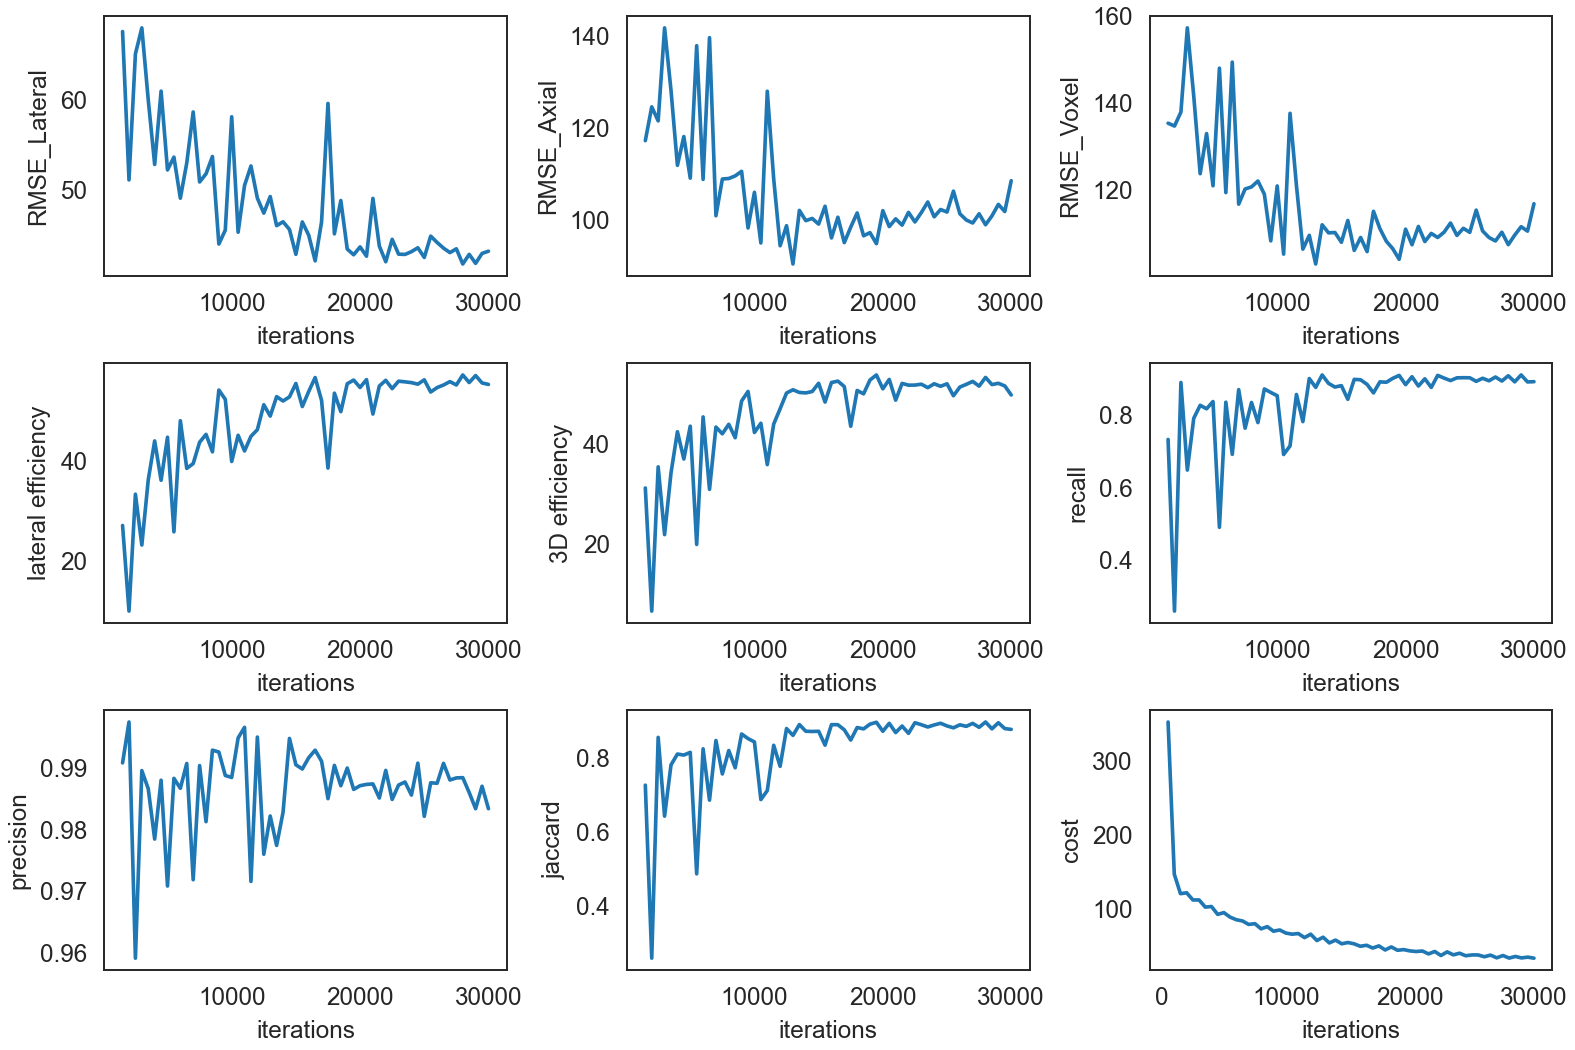

In [4]:
# load the completely trained FD_DECODE model
with open(network_path, 'rb') as f:
    model = pickle.load(f)

# plot performance during the training
plot_train_record(model)

## 4. Check a specific experiment frame and corresponding network's multi-channel predictions.
* `plot_num`: The number of specific image that will be checked, better $\geq$ 5 (considering temporal context and background estimation)
* `nms`: If False, only use a simple threshold `nms_thre` to filter probability channel to get the deterministic pixels. If True, probability channel pixels with value>`candi_thre` will be treated as candidates for local maximum searching. Then add the values from the 4 adjacent pixels to local maximums and filter the modified probability channel with the threshold `nms_thre` to get deterministic pixel-level localizations.
* `rescale_xy`: Rescales _x_ and _y_ offsets (inplace) so that they are distributed uniformly within [-0.5, 0.5] to correct for biased outputs (usually False).
* `pixel_size`,`start_field_pos` are explained before.
* `divide_and_conquer`: Divide the large images into small sub-area images. This is necessary as large input images may lead to GPU memory problem, this enables the network process the large images by sub-areas.
* `win_size`: If `divide_and_conquer`=True, set the size of sub-areas to be analyzed, must be a multiple of 4 (avoid error when down-sampling or up-sampling).
* `padding`: If `divide_and_conquer`=True and `padding`=True, this will segment a larger area (20 pixels) than `win_size` and traverse with overlap to avoid error from incomplete PSFs at margin.

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


<IPython.core.display.Javascript object>


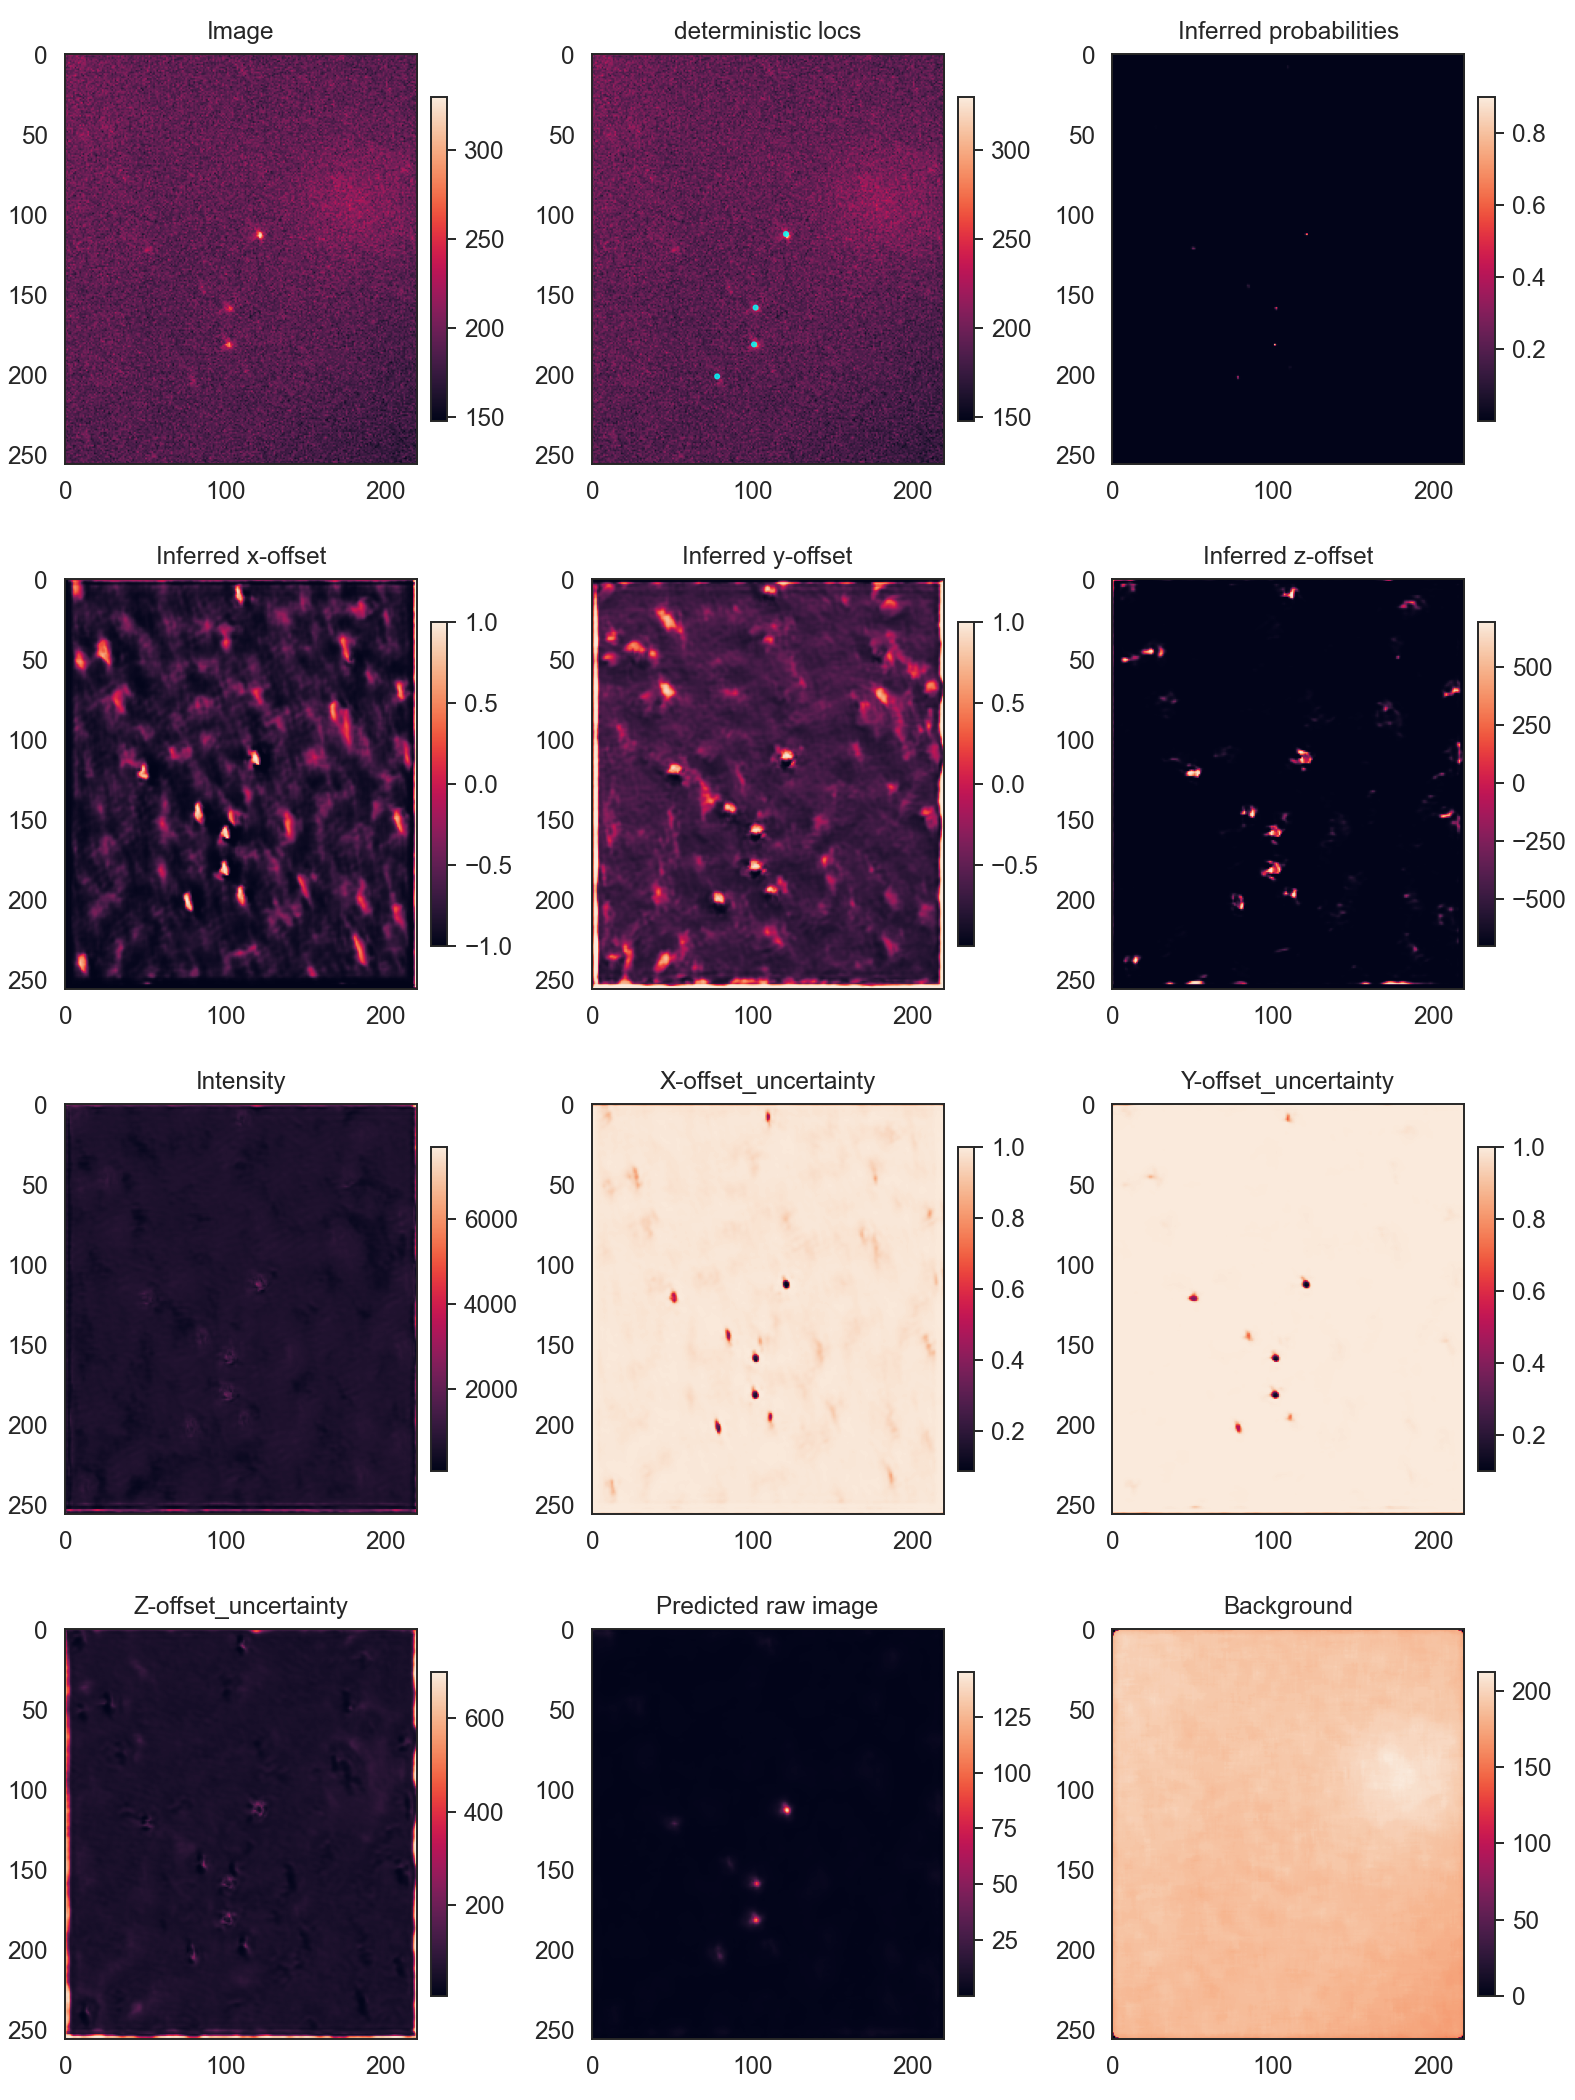

<IPython.core.display.Javascript object>


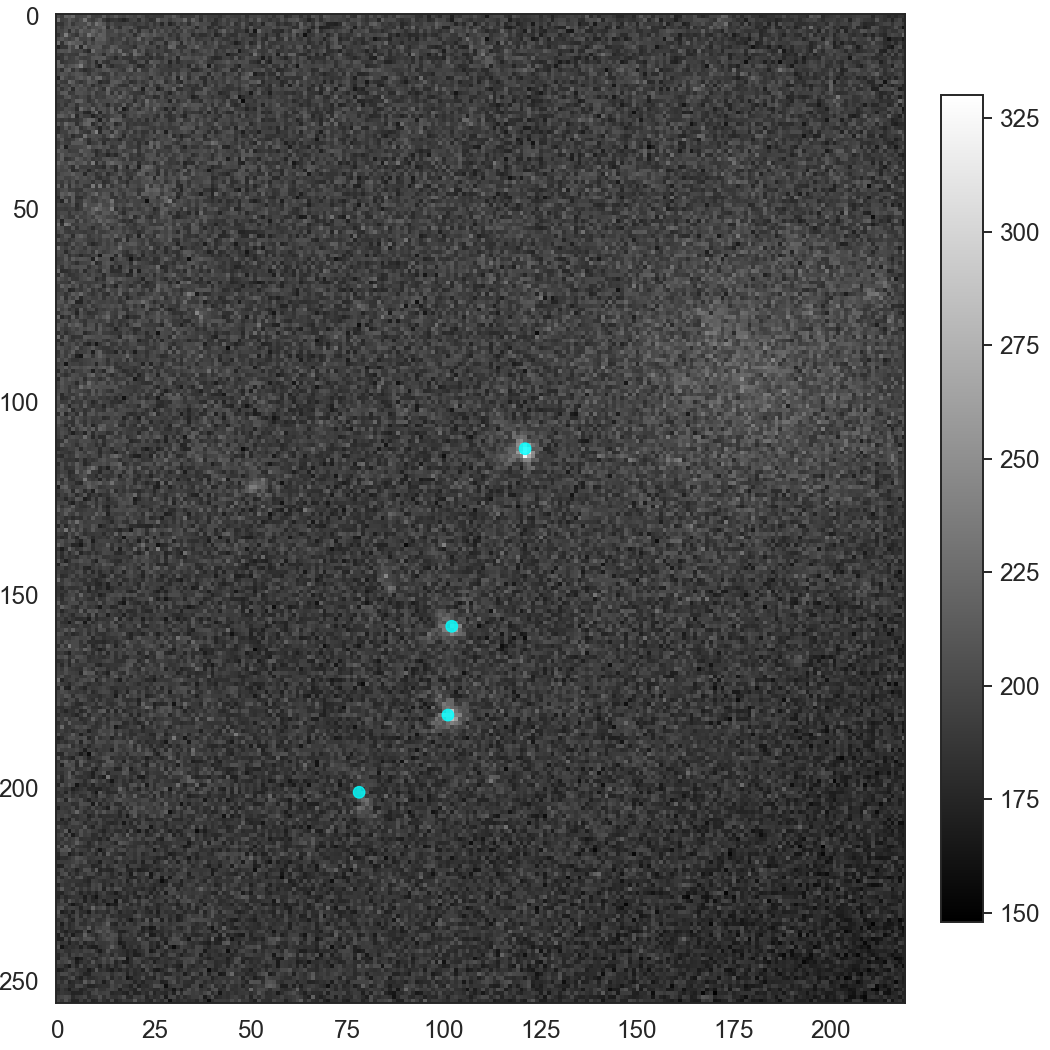

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


<IPython.core.display.Javascript object>


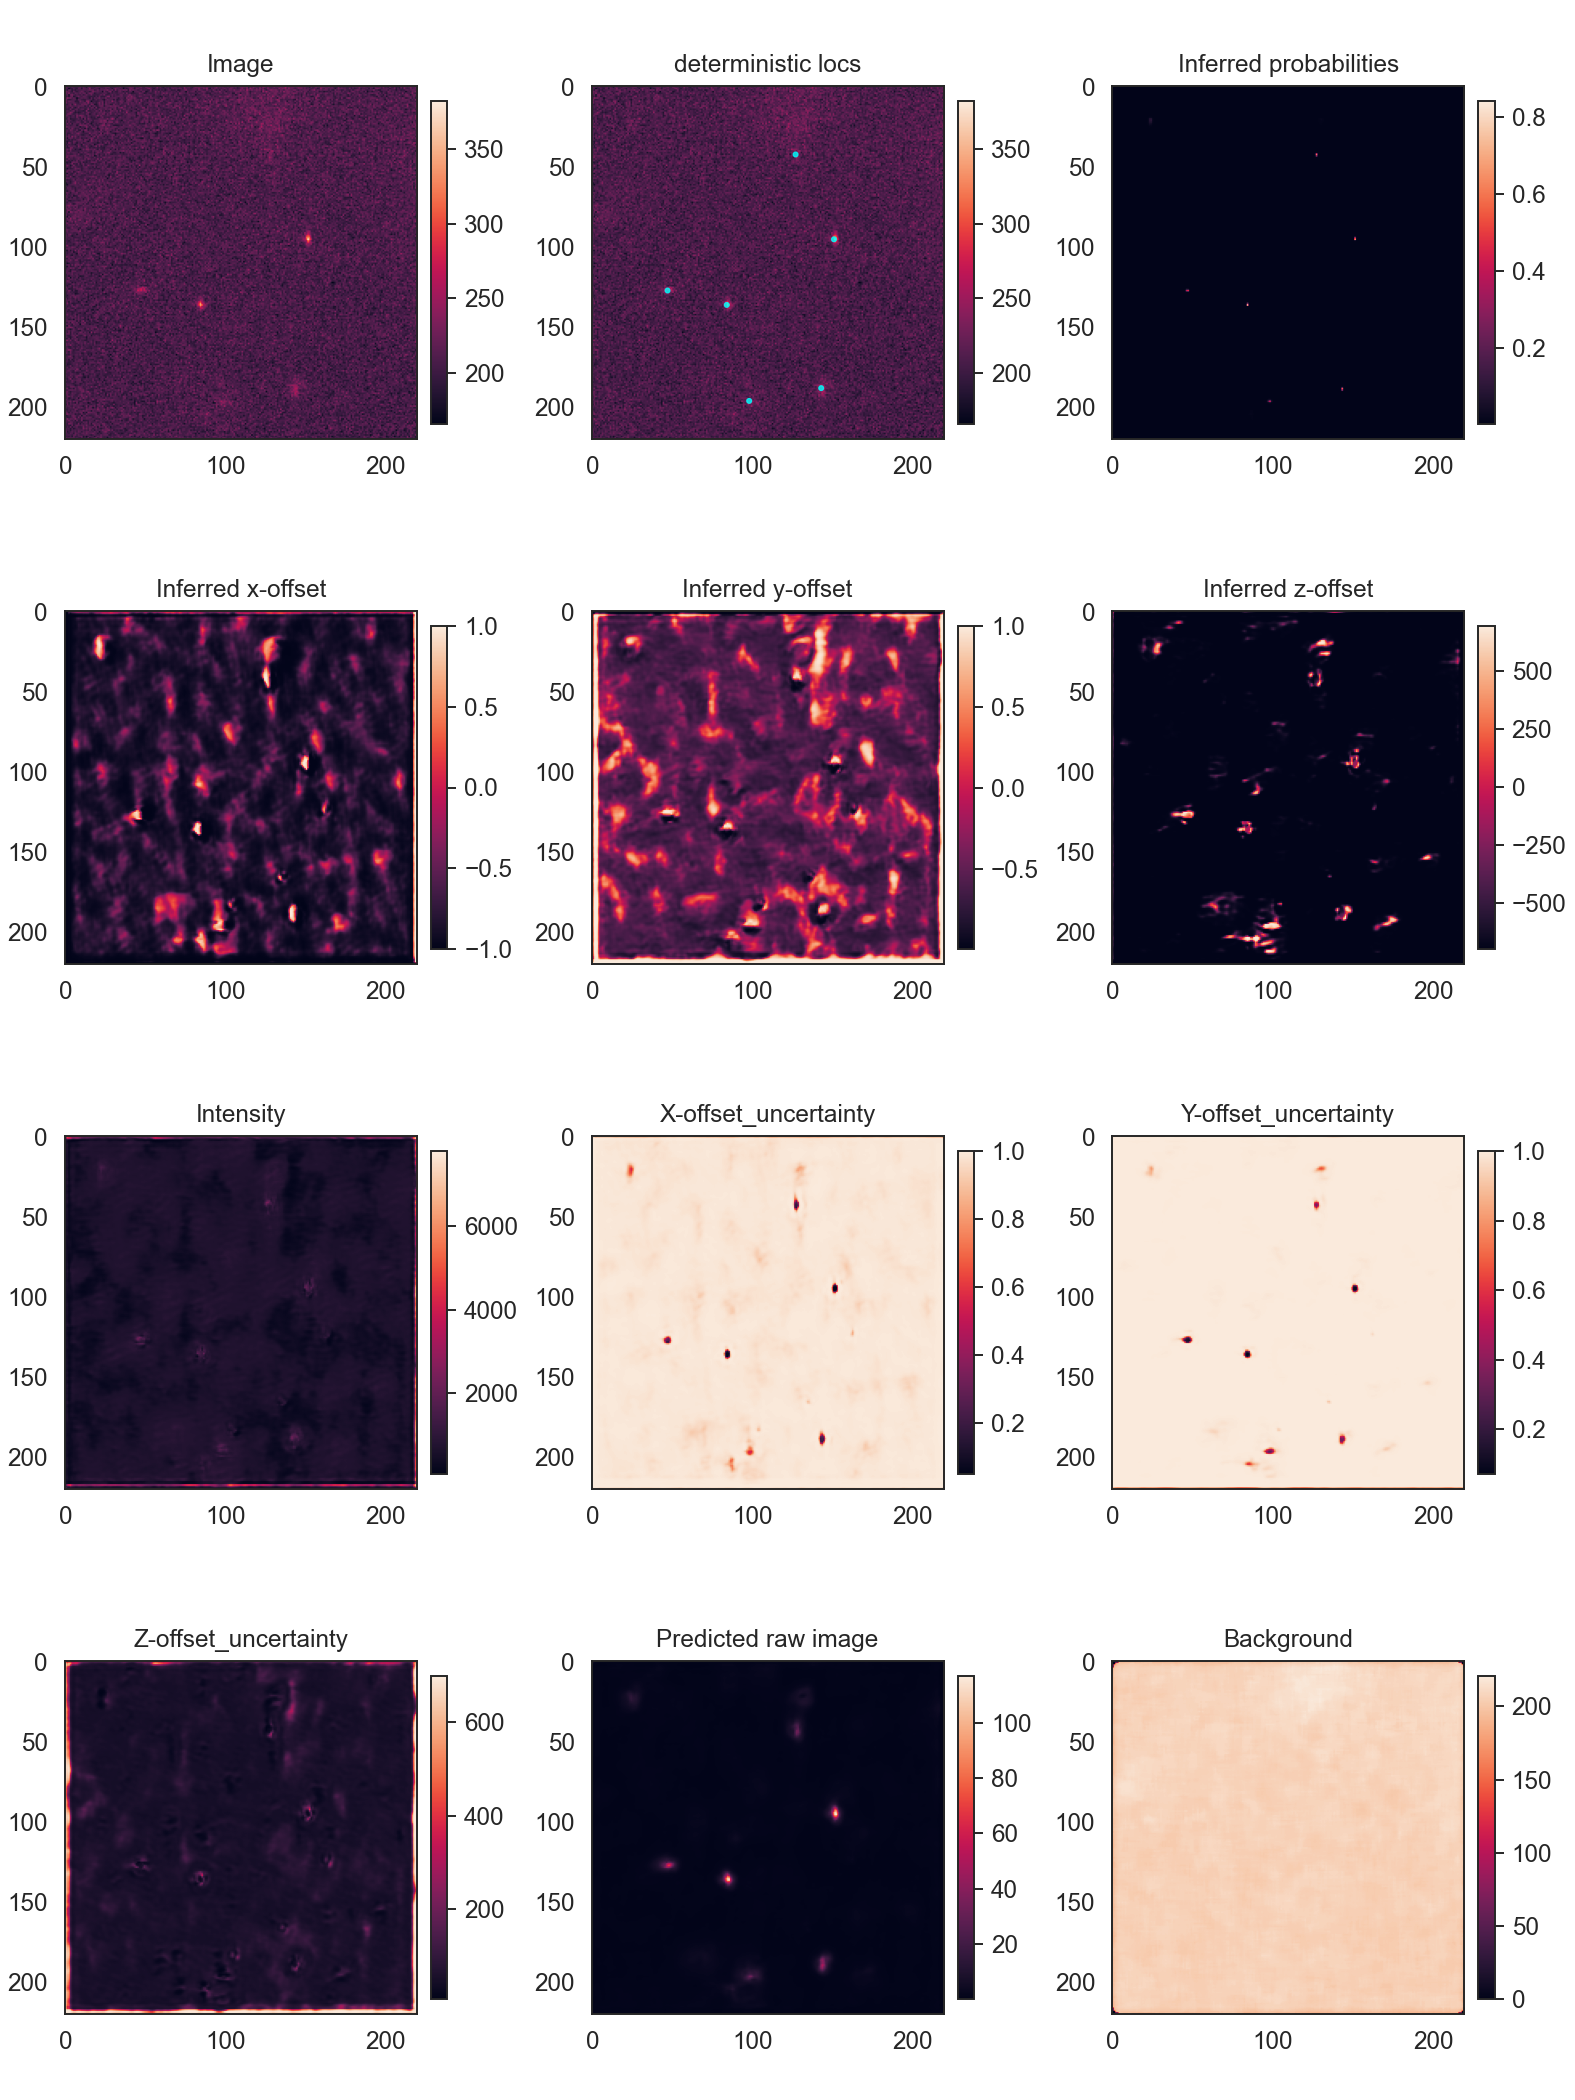

<IPython.core.display.Javascript object>


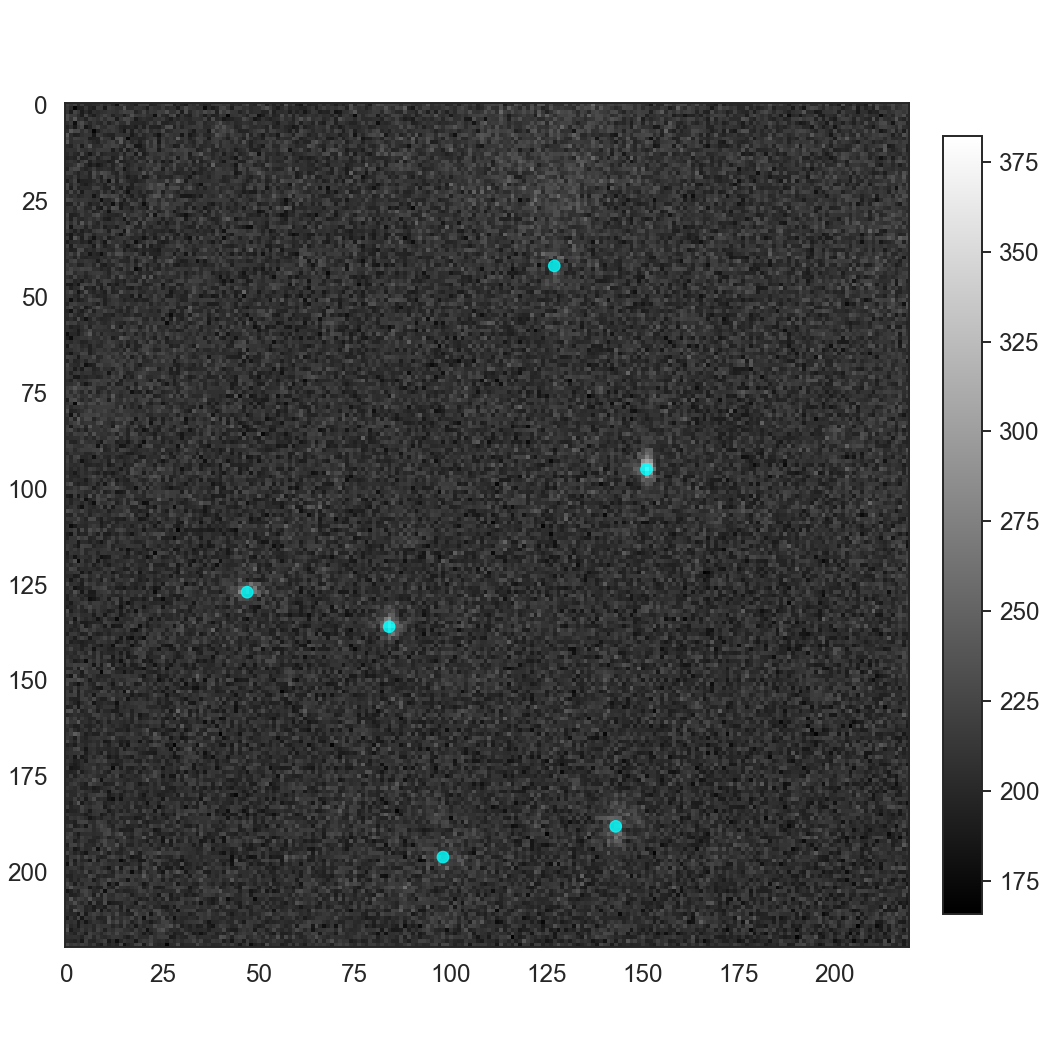

In [5]:
# check the specified frame and corresponding multi-channel output
check_specific_frame_output(plot_num=18, model=model, image_path=image_path_roi1, eval_csv=None,
                            nms=True, candi_thre=0.3, nms_thre=0.3, rescale_xy=False, pixel_size=pixel_size,
                            start_field_pos=start_field_pos_roi1, divide_and_conquer=True, win_size=256, padding=True)


check_specific_frame_output(plot_num=18, model=model, image_path=image_path_roi2, eval_csv=None,
                            nms=True, candi_thre=0.3, nms_thre=0.3, rescale_xy=False, pixel_size=pixel_size,
                            start_field_pos=start_field_pos_roi2, divide_and_conquer=True, win_size=256, padding=True)

## 5. Start inferring.
Read big tiff and predict, save the predictions every finish processing `stack_giga`-sized SMLM images, even some accidents happen you will not lose all results. If there is already a prediction file with the same name as `save_path`, inference will start from the last saved frame number in the `save_path` file. We recommend using SMAP to postprocess the prediction list (drift correction, grouping, etc.) and render the super-resolution image (Ries, J. SMAP: a modular super-resolution microscopy analysis platform for SMLM data. Nat Methods 17, 870–872 (2020). https://doi.org/10.1038/s41592-020-0938-1). 
* The parameters haven been explained before.

In [6]:
# read big tiff and predict, save the predictions every finish processing stack_giga-sized SMLM images,
# even some accidents happen you will not lose all results
total_shape,fov_size = read_bigtiff_and_predict(model, image_path_roi1, stack_giga=stack_giga, batch_size=10,
                                                use_tqdm=True, nms=True, candi_thre=0.3, nms_thre=0.3,
                                                rescale_xy=False, pixel_size=pixel_size, start_field_pos=start_field_pos_roi1, 
                                                divide_and_conquer=True, win_size=256, padding=True, save_path=save_path_roi1)

the file to save the predictions is:  ./demo2_FD-DeepLoc_roi_startpos_1280_1250.csv
stack: 1/22, contain imgs: 4583, already analyzed:0/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.63it/s]



stack: 2/22, contain imgs: 4583, already analyzed:4583/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.51it/s]



stack: 3/22, contain imgs: 4583, already analyzed:9166/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.72it/s]



stack: 4/22, contain imgs: 4583, already analyzed:13749/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.61it/s]



stack: 5/22, contain imgs: 4583, already analyzed:18332/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.61it/s]



stack: 6/22, contain imgs: 4583, already analyzed:22915/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.62it/s]



stack: 7/22, contain imgs: 4583, already analyzed:27498/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.54it/s]



stack: 8/22, contain imgs: 4583, already analyzed:32081/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.51it/s]



stack: 9/22, contain imgs: 4583, already analyzed:36664/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.55it/s]



stack: 10/22, contain imgs: 4583, already analyzed:41247/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.54it/s]



stack: 11/22, contain imgs: 4583, already analyzed:45830/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.51it/s]



stack: 12/22, contain imgs: 4583, already analyzed:50413/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.56it/s]



stack: 13/22, contain imgs: 4583, already analyzed:54996/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:34<00:00, 13.49it/s]



stack: 14/22, contain imgs: 4583, already analyzed:59579/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.51it/s]



stack: 15/22, contain imgs: 4583, already analyzed:64162/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:34<00:00, 13.48it/s]



stack: 16/22, contain imgs: 4583, already analyzed:68745/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:34<00:00, 13.47it/s]



stack: 17/22, contain imgs: 4583, already analyzed:73328/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:34<00:00, 13.50it/s]



stack: 18/22, contain imgs: 4583, already analyzed:77911/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:34<00:00, 13.49it/s]



stack: 19/22, contain imgs: 4583, already analyzed:82494/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.52it/s]



stack: 20/22, contain imgs: 4583, already analyzed:87077/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.51it/s]



stack: 21/22, contain imgs: 4583, already analyzed:91660/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:34<00:00, 13.46it/s]



stack: 22/22, contain imgs: 4583, already analyzed:96243/100826

processing area:1/1, input field_xy:[1280 1499 1250 1505], use_coordconv:True, retain locs in area:[1280, 1499, 1250, 1505], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [00:33<00:00, 13.51it/s]



analysis finished ! the file containing results is: ./demo2_FD-DeepLoc_roi_startpos_1280_1250.csv


In [7]:
total_shape,fov_size = read_bigtiff_and_predict(model, image_path_roi2, stack_giga=stack_giga, batch_size=10,
                                                use_tqdm=True, nms=True, candi_thre=0.3, nms_thre=0.3,
                                                rescale_xy=False, pixel_size=pixel_size, start_field_pos=start_field_pos_roi2, 
                                                divide_and_conquer=True, win_size=256, padding=True, save_path=save_path_roi2)

the file to save the predictions is:  ./demo2_FD-DeepLoc_roi_startpos_810_790.csv
stack: 1/20, contain imgs: 5306, already analyzed:0/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.59it/s]



stack: 2/20, contain imgs: 5306, already analyzed:5306/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.55it/s]



stack: 3/20, contain imgs: 5306, already analyzed:10612/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.51it/s]



stack: 4/20, contain imgs: 5306, already analyzed:15918/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.56it/s]



stack: 5/20, contain imgs: 5306, already analyzed:21224/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.51it/s]



stack: 6/20, contain imgs: 5306, already analyzed:26530/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.54it/s]



stack: 7/20, contain imgs: 5306, already analyzed:31836/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.44it/s]



stack: 8/20, contain imgs: 5306, already analyzed:37142/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.51it/s]



stack: 9/20, contain imgs: 5306, already analyzed:42448/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.47it/s]



stack: 10/20, contain imgs: 5306, already analyzed:47754/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.48it/s]



stack: 11/20, contain imgs: 5306, already analyzed:53060/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.36it/s]



stack: 12/20, contain imgs: 5306, already analyzed:58366/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.46it/s]



stack: 13/20, contain imgs: 5306, already analyzed:63672/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.50it/s]



stack: 14/20, contain imgs: 5306, already analyzed:68978/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:35<00:00, 15.16it/s]



stack: 15/20, contain imgs: 5306, already analyzed:74284/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:35<00:00, 14.78it/s]



stack: 16/20, contain imgs: 5306, already analyzed:79590/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:34<00:00, 15.18it/s]



stack: 17/20, contain imgs: 5306, already analyzed:84896/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:35<00:00, 15.10it/s]



stack: 18/20, contain imgs: 5306, already analyzed:90202/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:35<00:00, 15.06it/s]



stack: 19/20, contain imgs: 5306, already analyzed:95508/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:35<00:00, 14.98it/s]



stack: 20/20, contain imgs: 12, already analyzed:100814/100826

processing area:1/1, input field_xy:[ 810 1029  790 1009], use_coordconv:True, retain locs in area:[810, 1029, 790, 1009], aber_map size:(1608, 1608, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]


analysis finished ! the file containing results is: ./demo2_FD-DeepLoc_roi_startpos_810_790.csv


### filter and render (recommend to be done in SMAP)

F:\users\FS\FD_DeepLoc_refac\local_utils\plot_funcs.py:98: RuntimeWarning: invalid value encountered in divide
  zavg = zsum / density
F:\users\FS\FD_DeepLoc_refac\local_utils\plot_funcs.py:98: RuntimeWarning: invalid value encountered in divide
  zavg = zsum / density


<IPython.core.display.Javascript object>


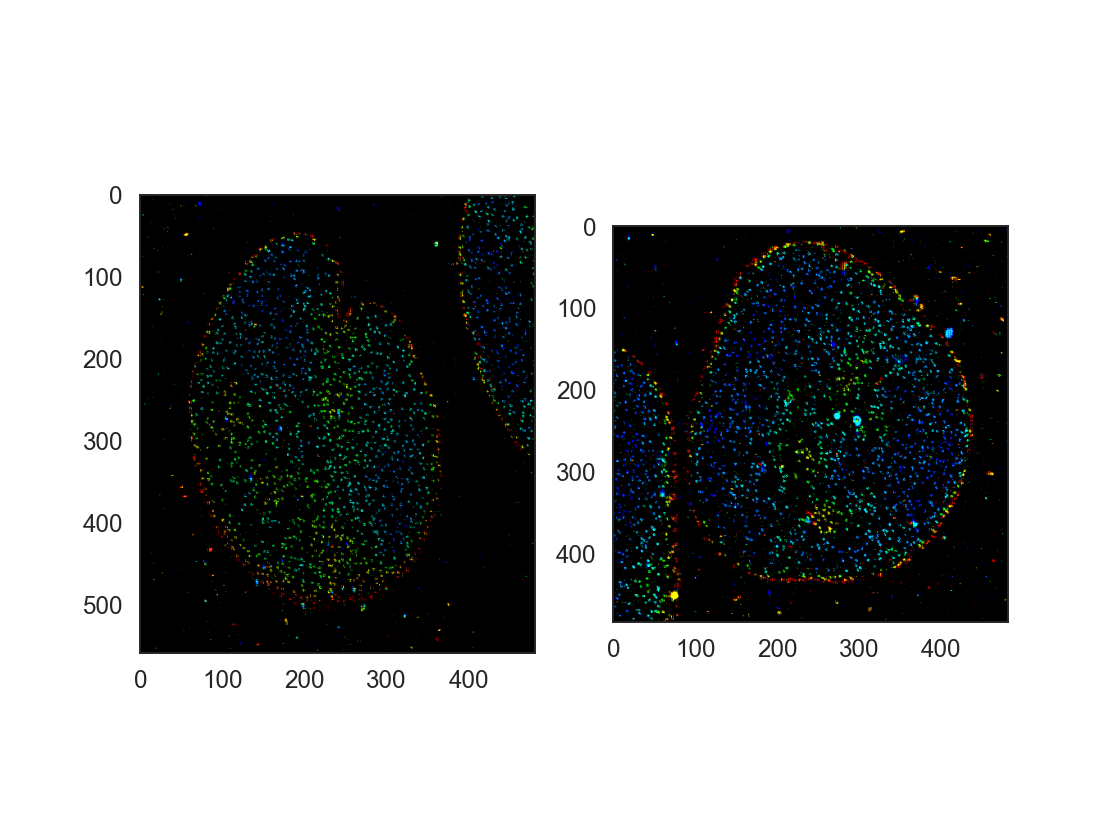

In [8]:
# read the prediction list
# render, if the FOV is very big, this might be slow and cost large RAM, 
# you may need a postprocessing software to do drift correction and grouping for better image rendering.    
preds_roi1 = read_csv(save_path_roi1).tolist()
hist_img_roi1 = create_3d_hist(preds_roi1, z_clip=[-300, 600], pix_size=50, sigma=10, contrast_fac=100)

preds_roi2 = read_csv(save_path_roi2).tolist()
hist_img_roi2 = create_3d_hist(preds_roi2, z_clip=[-300, 600], pix_size=50, sigma=10, contrast_fac=100)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(hist_img_roi1)
plt.subplot(1,2,2)
plt.imshow(hist_img_roi2)

<IPython.core.display.Javascript object>


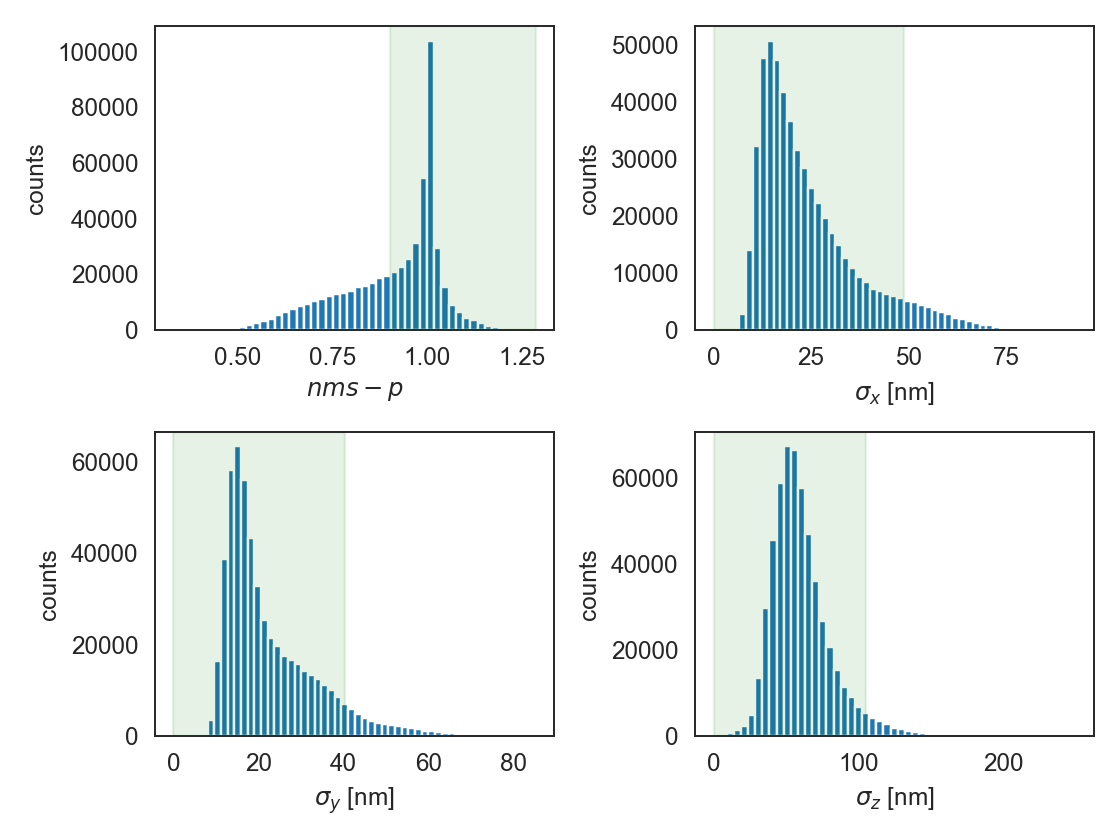

<IPython.core.display.Javascript object>


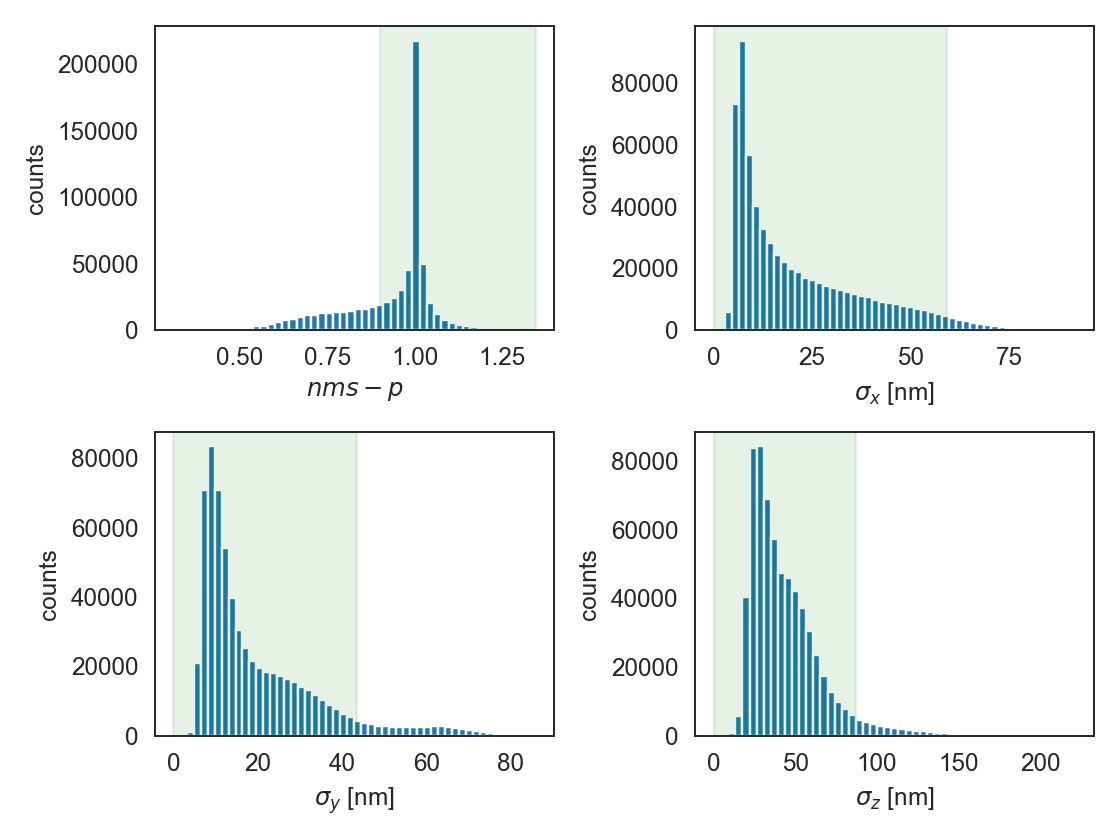

<IPython.core.display.Javascript object>


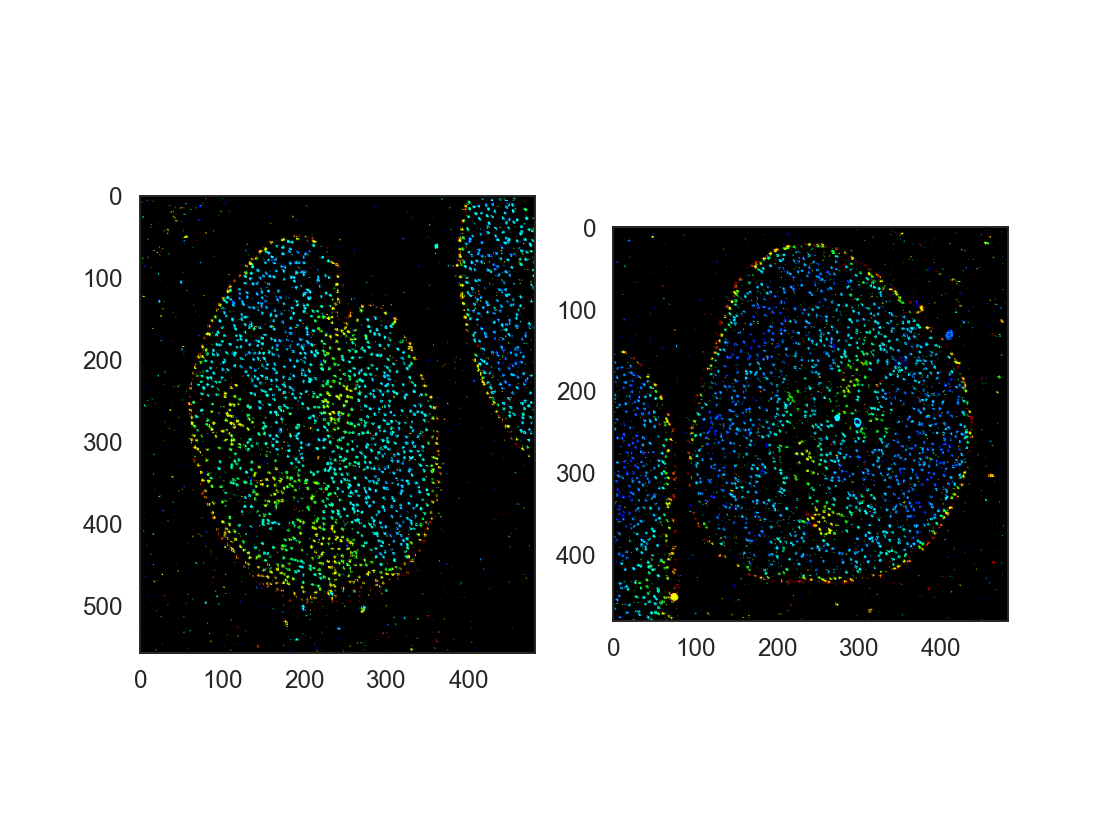

In [9]:
# filter the raw predictions by probability channel and uncertainty channel (can also be done in SMAP)
preds_roi1_filtered = filt_preds(preds_roi1, nms_p_thre=0.9, sig_perc=95, is_3d=True)
fig, axes = plot_preds_distribution(preds_roi1,preds_roi1_filtered)
hist_img_roi1_filtered = create_3d_hist(preds_roi1_filtered, z_clip=[-300, 600], pix_size=50, sigma=10, contrast_fac=100)

preds_roi2_filtered = filt_preds(preds_roi2, nms_p_thre=0.9, sig_perc=95, is_3d=True)
fig, axes = plot_preds_distribution(preds_roi2,preds_roi2_filtered)
hist_img_roi2_filtered = create_3d_hist(preds_roi2_filtered, z_clip=[-300, 600], pix_size=50, sigma=10, contrast_fac=100)

# render, if the FOV is very big, this might be slow and cost large RAM
plt.figure()
plt.subplot(1,2,1)
plt.imshow(hist_img_roi1_filtered)
plt.subplot(1,2,2)
plt.imshow(hist_img_roi2_filtered)